In [1]:
import pandas as pd

dataset = pd.read_csv("../datasets/penguins.csv")

feature_names = [
    "Culmen Length (mm)",
    "Culmen Depth (mm)",
    "Flipper Length (mm)",
]
target_name = "Body Mass (g)"

dataset = dataset[feature_names + [target_name]].dropna(axis="rows", how="any")
dataset = dataset.sample(frac=1, random_state=0).reset_index(drop=True)
data, target = dataset[feature_names], dataset[target_name]

### RandomForestRegressor

We determine and plot the validation curve of the n_estimators parameters defined by:
n_estimators = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1_000]



In [2]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0)
n_estimators = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1_000]
train_scores, test_scores = validation_curve(
    rf, data, target, param_name="n_estimators", param_range=n_estimators, cv=10, n_jobs=2
  )

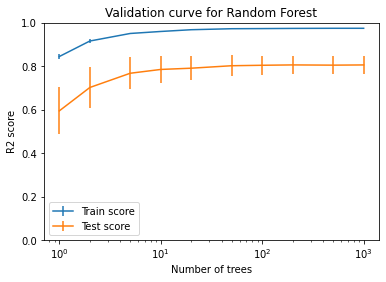

In [8]:
import matplotlib.pyplot as plt

plt.errorbar(
    n_estimators,
    train_scores.mean(axis=1),
    yerr=train_scores.std(axis=1),
    label="Train score",
)
plt.errorbar(
    n_estimators,
    test_scores.mean(axis=1),
    yerr=test_scores.std(axis=1),
    label="Test score",
)
plt.legend()
plt.xscale("log")
plt.xlabel("Number of trees")
plt.ylabel("R2 score")
plt.ylim([0, 1])
_ = plt.title("Validation curve for Random Forest")


We observe that above 500 trees, both the train and test scores become nearly constant. This diminishing returns effect is typical of Random Forests and bagging ensembles in general.

In [17]:
test_scores.mean(), test_scores.std()

(0.7656133008477611, 0.0917704534353547)

#### RandomForestRegressor with `max_depth=5`

Instead of choosing the default parameters for the random forest, we set the parameter `max_depth=5` and build the validation curve coomparing the validation curve (train and test scores) of the random forest with a full depth and the random forest with a limited depth.

In [13]:
rf5 = RandomForestRegressor(max_depth=5, random_state=0)
n_estimators = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1_000]
train_scores5, test_scores5 = validation_curve(
    rf5, data, target, param_name="n_estimators", param_range=n_estimators, cv=10, n_jobs=2
  )

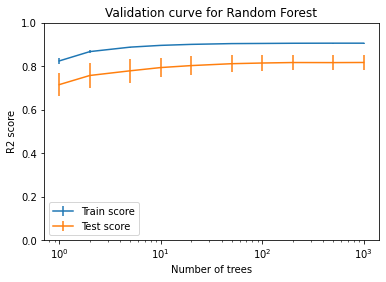

In [14]:
plt.errorbar(
    n_estimators,
    train_scores5.mean(axis=1),
    yerr=train_scores5.std(axis=1),
    label="Train score",
)
plt.errorbar(
    n_estimators,
    test_scores5.mean(axis=1),
    yerr=test_scores5.std(axis=1),
    label="Test score",
)
plt.legend()
plt.xscale("log")
plt.xlabel("Number of trees")
plt.ylabel("R2 score")
plt.ylim([0, 1])
_ = plt.title("Validation curve for Random Forest")

In [18]:
test_scores5.mean(), test_scores5.std()

(0.7917801336150552, 0.0540743610652205)

We see that decreasing the depth reduces the gap between the train and test scores. We also see that the random forest with limited depth has a better generalization performance for a small number of trees but becomes equivalent for higher numbers of trees. We can conclude that the random forest models with a limited depth overfit less than the random forest with fully grown trees, especially when the number of trees in the ensemble is small.

One can also observe that the limiting the depth has a significant effect on limiting the training score (ability to memorize exactly the training data) and that this effect remains important, even when increasing the size of the ensemble.

### HistGradientBoostingRegressor

We determine and plot the validation curve with: max_iter = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1_000]

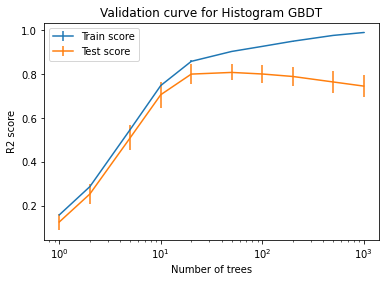

In [15]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbdt = HistGradientBoostingRegressor(random_state=0)
max_iter = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1_000]
train_scores_hgbdt, test_scores_hgbdt = validation_curve(
    hgbdt, data, target, param_name="max_iter", param_range=n_estimators, cv=10, n_jobs=2
)
plt.errorbar(
    n_estimators,
    train_scores_hgbdt.mean(axis=1),
    yerr=train_scores_hgbdt.std(axis=1),
    label="Train score",
)
plt.errorbar(
    n_estimators,
    test_scores_hgbdt.mean(axis=1),
    yerr=test_scores_hgbdt.std(axis=1),
    label="Test score",
)
plt.xscale("log")
plt.legend()
plt.xlabel("Number of trees")
plt.ylabel("R2 score")
_ = plt.title("Validation curve for Histogram GBDT")

In [19]:
test_scores_hgbdt.mean(), test_scores_hgbdt.std()

(0.6303109120677418, 0.24234317129198818)

In the figure, we can clearly observe the three phase behavior "underfitting / best generalization / overfitting" of gradient boosting models. Indeed, with a low number of trees, the model has a low score for both the train and test scores. We can clearly see that the test scores are bound above by the train score, which is characteristic of underfitting models (contrary to what we previously observed on the learning curve of the RF models).


Both scores then improve until a sweet spot (~50 trees) where the test score is maximum. After this, the gradient boosting algorithm starts to overfit: the train score improves towards reaching a perfect score of 1 while the test score reduces. Indeed, the model starts to memorize specific rules only true on the training set. These rules become detrimental on the generalization performance of the model.

#### `early-stopping=True` in HGBT

Here, it shows the importance of not adding too many trees to our gradient boosting ensemble. Indeed, one can use **early-stopping** and monitor the performance on an internal validation set to stop adding new trees when the validation score stops improving. Here is an example to show how to do this automatically:


In [21]:
from sklearn.model_selection import cross_validate

hgbdt = HistGradientBoostingRegressor(early_stopping=True, random_state=0)
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, cv=10, return_train_score=True, return_estimator=True
)
cv_results_hgbdt["train_score"].mean(), cv_results_hgbdt["train_score"].std()



(0.8802093174685013, 0.009772033922083758)

We see that the train score is not perfect meaning that our model stopped much before adding too many trees. We can check the generalization performance to ensure that an equivalent model to the previous random forest:




In [22]:
cv_results_hgbdt["test_score"].mean(), cv_results_hgbdt["test_score"].std()


(0.8075456252855009, 0.030400979794505564)

So we observe that on average, the model performs as good as a large random forest.
Finally, we can check how many trees where used for each CV iteration:

In [23]:
for idx, est in enumerate(cv_results_hgbdt["estimator"]):
    print(
        f"For CV iteration {idx + 1}, {est.n_iter_} trees were built"
    )

For CV iteration 1, 60 trees were built
For CV iteration 2, 50 trees were built
For CV iteration 3, 46 trees were built
For CV iteration 4, 29 trees were built
For CV iteration 5, 33 trees were built
For CV iteration 6, 33 trees were built
For CV iteration 7, 36 trees were built
For CV iteration 8, 31 trees were built
For CV iteration 9, 24 trees were built
For CV iteration 10, 23 trees were built


We therefore see that we never used more than 60 trees, before entering the overfitting zone we observed on the validation curve.

Even if this model is not stronger than a large random forest, it is smaller which means that it can be much faster to predict and will use fewer memory (RAM) on the machines where it is deployed. This is a practical advantage of Gradient Boosted Trees with early stopping over Random Forests with a large number of deep trees.